In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

In [2]:
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']

In [3]:
df_all = pd.concat(all_dataframes)

In [4]:
df_all.head()

,jobId,jobUrl,jobTitle,jobDescription,datePosted,companyId,companyName,industryId,yoxMin,yoxMax,finalWageMin,finalWageMax,countryCode,skills,qualifications
0,0023502d439415ad8bbdb62a7020114c0e67ed5824e0b6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
1,0053799fde5277b3ee431bb57f0820ef01a4c6abf7246d...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
2,009bd6514108fed114208aa85c28a2c318291978e301ee...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
3,00edb53a28e215cfb3f8d90594fac0872919bba772d842...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
4,01103f9a143bdecf5e09484315bd1a2fb36fe9e7acbca6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']


In [5]:
df_all.industryId.unique()

array(['InfoComm Technologies'], dtype=object)

In [6]:
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [7]:
df_all_useful_cols.head()

,Company,Date,Industry,Skill,Skill Type
0,MILWORKS SOLUTIONS PTE. LTD.,2020-01-01,InfoComm Technologies,accounts payable accounting,2
1,Red Hat,2018-01-01,InfoComm Technologies,virtualization technology,1
2,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,account management,2
3,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,business development,1
4,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,communication,4


In [8]:
company_totals.sum()

Company    01 Computer System Pte Ltd01 Computer System P...
Total                                                  37413
dtype: object

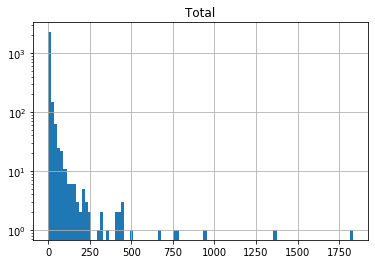

In [9]:
company_totals.groupby('Company').sum().hist(bins=100)
plt.yscale('log')

In [10]:
company_totals['year'] = company_totals.Date.apply(lambda x: x.year)
company_totals.groupby('year').sum()

,Total
year,
2017,4516
2018,9915
2019,17835
2020,5147


If we want to filter out the irrelevant skill types (which I need to figure out), here is the place.

In [11]:
df_all_useful_cols['Skill Type'].unique()

array([2, 1, 4, 3])

In [12]:
df_all_useful_cols.loc[df_all_useful_cols['Skill Type'] == 1].groupby('Skill').count().\
            sort_values('Date', ascending=False).index.values.tolist()

['computer science',
 'cloud technology',
 'regulatory compliance',
 'sops/best practices',
 'consulting',
 'unix/linux',
 'hardware',
 'information technology',
 'business finance',
 'business development',
 'microsoft windows os',
 'web services',
 'social media (facebook)',
 'legal/law',
 'computer engineering',
 'data center',
 'telecommunications',
 'social media',
 'healthcare',
 'operating systems',
 'supply chain & logistics',
 'scrum/agile',
 'amazon web services',
 'information systems',
 'e-commerce',
 'virtualization technology',
 'web applications',
 'sdlc',
 'advertising',
 'software-as-a-service (saas)',
 'investment',
 'open source technology',
 'vmware',
 'manufacturing',
 'system engineering',
 'genetic information',
 'continuous improvement',
 'human resource development',
 'b2b engagement',
 'business administration',
 'machine learning algorithms',
 'compensation & benefits',
 'artificial intelligence',
 'iso',
 'big data',
 'marketing strategy',
 'cyber security',

Skill type 3 is languages and licenses, 4 is general soft skills.

Types 1 and 2 are both hard skills, the difference being that type 1 deals with more generic skills and with clusters, while 2 deals with specific technology for the most part.

In [13]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')

In [14]:
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)

In [15]:
sorted(list(it_skills))

['.net',
 '3d graphics',
 '3d modeling',
 'a/b testing',
 'ab initio',
 'account management',
 'accounting information systems',
 'aconex',
 'active directory',
 'active directory federation services (adfs)',
 'adas (architecture design and assessment system)',
 'admission & ticket management',
 'ado.net',
 'adobe acrobat pro',
 'adobe after effects',
 'adobe analytics',
 'adobe campaign',
 'adobe cq5',
 'adobe creative suite',
 'adobe dreamweaver',
 'adobe experience manager',
 'adobe flash',
 'adobe illustrator',
 'adobe indesign',
 'adobe lightroom',
 'adobe marketo',
 'adobe phonegap',
 'adobe photoshop',
 'adobe premiere pro',
 'adobe xd',
 'aecosim',
 'ahrefs (seo)',
 'airflow',
 'aix',
 'ajax',
 'algorithm design',
 'altera quartus',
 'amazon dynamodb',
 'amazon redshift',
 'amazon web services',
 'aml/cft',
 'amortization',
 'ampl',
 'amqp',
 'anaconda',
 'analytical design',
 'android',
 'android sdk',
 'android studio',
 'angularjs',
 'animation',
 'annuity',
 'anova',
 'ansi

In [16]:
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [17]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,year,Job Postings
124152,M1 Limited,python,2017-01-01,2,22,2017,0.090909
100834,IHIS - Integrated Health Information Systems P...,ssl/tls,2017-01-01,1,15,2017,0.066667
100833,IHIS - Integrated Health Information Systems P...,sql,2017-01-01,1,15,2017,0.066667
15900,Agilysys Singapore Pte Ltd,system integration,2017-01-01,1,2,2017,0.500000
15899,Agilysys Singapore Pte Ltd,sql,2017-01-01,1,2,2017,0.500000
15895,Agilysys Singapore Pte Ltd,pos system,2017-01-01,1,2,2017,0.500000
15894,Agilysys Singapore Pte Ltd,multi-task,2017-01-01,1,2,2017,0.500000
15893,Agilysys Singapore Pte Ltd,microsoft office suite,2017-01-01,1,2,2017,0.500000
15892,Agilysys Singapore Pte Ltd,microsoft office (powerpoint),2017-01-01,1,2,2017,0.500000
15891,Agilysys Singapore Pte Ltd,microsoft office (excel),2017-01-01,1,2,2017,0.500000


In [18]:
len(skills_df.Skill.unique())

987

In [19]:
# skills_df[['Skill']].drop_duplicates().sort_values('Skill').to_csv('./all_skills.csv')

## Computing the true emerging skills

In [21]:
monthly_totals = compute_total_values(skills_df)
total_log = compute_total_poptype_mean(skills_df)

In [21]:
start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
                       (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

# start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')), 
#                        (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

total_values = [get_period_of_time(monthly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]

In [22]:
skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log, nologtest=False, smoothing='exp', degree=2) 
                                for i in range(len(start_and_end_dates))]

Start: 2017-01-01
End: 2018-01-01
Number of skills: 684
            Slope   Intercept  Acceleration    Spikiness
count  684.000000  684.000000    684.000000   684.000000
mean    -0.102545    1.243601      0.011574     2.150970
std      0.304963    3.364524      0.029906    68.009438
min     -2.612384   -0.447202     -0.083176  -874.381836
25%     -0.185977   -0.167908     -0.001890    -0.782586
50%     -0.078386    0.090948      0.006052     0.118946
75%      0.009142    0.951472      0.017828     1.927302
max      1.218713   29.872103      0.336716  1501.943135
Start: 2018-01-01
End: 2019-01-01
Number of skills: 847
            Slope   Intercept  Acceleration   Spikiness
count  847.000000  847.000000    847.000000  847.000000
mean    -0.283462    2.510417      0.033401    0.806172
std      0.619226    6.673883      0.069708   21.651720
min     -6.458252   -0.595339     -0.065523 -446.328754
25%     -0.309835   -0.163505      0.002705   -0.224560
50%     -0.151609    0.296269      0.01

In [23]:
skill_trends[2].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.790975,-0.975462,-0.004674,0.887642
Intercept,0.790975,1.000000,-0.776550,0.001310,0.958587
Acceleration,-0.975462,-0.776550,1.000000,0.004965,-0.845176
Spikiness,-0.004674,0.001310,0.004965,1.000000,-0.000589
Job Postings Raw,0.887642,0.958587,-0.845176,-0.000589,1.000000


In [24]:
skill_trends[2].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.299434,-0.932742,0.183733,0.599479
Intercept,0.299434,1.000000,-0.295042,0.377147,0.872192
Acceleration,-0.932742,-0.295042,1.000000,-0.161236,-0.539497
Spikiness,0.183733,0.377147,-0.161236,1.000000,0.462420
Job Postings Raw,0.599479,0.872192,-0.539497,0.462420,1.000000


In [25]:
def remove_outliers(s):
#     return s.loc[(s<s.mean()+10*s.std()) & (s>s.mean()-10*s.std())]
    return s

In [26]:
def get_hybrid_score(df, cols, weights=None):
    if weights is None:
        weights = [1]*len(cols)
    return sum([weights[i]*np.log(1+(df[cols[i]] - remove_outliers(df[cols[i]]).min())/
                                  (remove_outliers(df[cols[i]]).max()-
                                   remove_outliers(df[cols[i]]).min()))
                if df[cols[i]].max() - df[cols[i]].min() > 0 else 0
                for i in range(len(cols)) ])

for skill_trend_df in skill_trends:
    skill_trend_df['HybridScore'] = get_hybrid_score(skill_trend_df, 
                                 ['Slope', 'Acceleration'], weights=[1,1])

In [27]:
emerging_skills = [threshold_logsum_trends_simple(skill_trends[i], total=total_values[i], col='HybridScore', 
                                  only_positives=True,
                                  col_percentile_thresh=0.75, col_std_thresh=None, 
                                  pop_lower_percentile=0, pop_upper_percentile=0.85) 
                        for i in range(len(skill_trends))]

In [28]:
emerging_skills[2]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
0,active directory,1.155304,6.863155,-0.096200,1.346889,196,0.751092
1,adobe creative suite,0.589536,0.185874,-0.037850,1.830691,55,0.747120
2,adobe indesign,0.107510,1.701128,0.003731,1.482465,73,0.739563
3,adobe premiere pro,0.152645,0.340772,0.000865,1.944618,39,0.740706
4,ansible,0.728904,5.327272,-0.036311,1.251677,182,0.754510
...,...,...,...,...,...,...,...
110,wide area network configuration,0.360529,2.884847,0.023170,1.844640,167,0.759656
111,wireframes,0.985950,3.634620,-0.085629,1.363049,127,0.747270
112,wordpress,0.356137,3.565013,-0.023360,1.320680,122,0.741354
113,xhtml,0.458502,-0.236513,-0.037387,2.701381,30,0.740881


In [29]:
compare_emerging_skill_sets(emerging_skills, start_and_end_dates, sort_type='score', sort_col='Slope')


Comparing 2017-01-01 to 2018-01-01 with 2018-01-01 to 2019-01-01

# of skills shared and exclusive to each date (in order)
29 72 80

The skills themselves:

Shared:

['relational database', 'bgp (border gateway protocol)', 'mpls', 'github', 'it service management', 'ospf', 'jenkins', 'mobile application development', 'data wrangling', 'powershell', 'google adwords', 'oracle database', 'data loss prevention', 'service oriented architecture', 'dynamic host configuration protocol', 'it operations management (itom)', 'financial analysis', 'mongodb', 'soap', 'predictive modelling', 'google go programming language', 'benchmarking', 'ruby', 'ibm websphere', 'jboss', 'platform-as-a-service (paas)', 'infrastructure-as-a-service (iaas)', 'micro-services', 'jira']

Exclusive to 2017-01-01 to 2018-01-01

['data center operations', 'system testing', 'uml', 'load balancer', 'root cause analysis', 'ajax', 'software architecture', 'microsoft hyper-v', 'nas infrastructure', 'linq', 'docker', 'geograph

['system testing', 'bgp (border gateway protocol)', 'mpls', 'github', 'it service management', 'source code', 'animation', 'data wrangling', 'powershell', 'openstack', 'oracle database', 'service oriented architecture', 'encryption/cryptography', 'splunk', 'dynamic host configuration protocol', 'penetration testing', 'financial analysis', 'confluence', 'mongodb', 'soap', 'knowledge management', 'practical malware analysis', 'ibm db2', 'google go programming language', 'benchmarking', 'ruby', 'ibm websphere', 'apache tomcat']

Exclusive to 2017-01-01 to 2018-01-01

['data center operations', 'uml', 'load balancer', 'relational database', 'root cause analysis', 'ajax', 'software architecture', 'microsoft hyper-v', 'nas infrastructure', 'linq', 'docker', 'geographic information system (gis)', 'mvc framework', 'ospf', 'database marketing', 'apache struts', 'laravel', 'jenkins', 'apache cordova', 'mobile application development', 'google adwords', 'apache maven', 'software engineering', 'es

# of skills shared and exclusive to each date (in order)
46 63 56

The skills themselves:

Shared:

['mpls', 'soap', 'bgp (border gateway protocol)', 'data quality control', 'postgresql', 'infrastructure-as-a-service (iaas)', 'data wrangling', 'oracle database', 'search engine optimization (seo)', 'swift', 'financial analysis', 'it service management', 'ospf', 'data/text mining', 'fintech', 'enterprise web architecture', 'github', 'mongodb', 'microsoft project', 'sdk', 'google analytics', 'process optimisation', 'service management', 'it operations management (itom)', 'jira', 'jboss', 'vb', 'powershell', 'cryptocurrency', 'shell scripts', 'ibm websphere', 'deep learning', 'resource management', 'jenkins', 'gaap', 'market analysis', 'react.js', 'platform-as-a-service (paas)', 'restful api', 'service oriented architecture', 'extract, transform, load (etl)', 'relational database', 'ruby', 'ansible', 'data structure', 'benchmarking']

Exclusive to 2018-01-01 to 2019-01-01

['dynamic host c

### Evaluating the sets of trending skills based on known (and obvious) ground truth

In [30]:
ground_truth_base = pd.DataFrame({'Skill': 
                    ['vue.js', 'deep learning', 'tensorflow', 'kubernetes', 'graphql',
                     'cryptocurrency', 'google go programming language', 'encryption/cryptography',
                     'redux', 'apache kafka', 'salesforce', 'aws lambda', 'amazon redshift', 'domo',
                     'data lakes', 'serverless computing', 'blockchain technology', 'amazon aurora', 
                     'docker', 'looker', 'autonomous cars', 'fintech', 'micro-services',
                     'data visualisation', 'apache hive', 'hadoop distributed file system', 
                     'apache flume', 'apache kafka', 'keras', 'predictive analytics',
                     'predictive modelling',
                     ]})

In [31]:
def find_nonexistent_skills(skills_to_find, skills_to_search_in):
    skills_to_find_list = skills_to_find.Skill.values
    results = list()
    for skill in skills_to_find_list:
        if skill not in skills_to_search_in.index.values:
            results.append(skill)
    print(results)
    return results, skills_to_find.loc[skills_to_find.Skill.apply(lambda x: x not in results)]

In [32]:
whatever, ground_truth_base = find_nonexistent_skills(ground_truth_base, pd.concat(skill_trends))

['aws lambda', 'domo', 'data lakes', 'serverless computing', 'amazon aurora', 'looker', 'autonomous cars']


In [33]:
compute_prec_recall(emerging_skills[0], ground_truth_base)


Correctly predicted skills:
{'docker', 'google go programming language', 'encryption/cryptography', 'micro-services', 'predictive modelling'}

Number of correctly predicted skills, all predicted positives, and true positives:
5 101 24


(0.04950495049504951, 0.20833333333333334, 0.08)

In [34]:
compute_prec_recall(emerging_skills[1], ground_truth_base)


Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'deep learning', 'google go programming language', 'apache kafka', 'predictive analytics', 'micro-services', 'blockchain technology', 'cryptocurrency', 'apache hive', 'vue.js', 'predictive modelling'}

Number of correctly predicted skills, all predicted positives, and true positives:
13 109 24


(0.11926605504587157, 0.5416666666666666, 0.1954887218045113)

In [35]:
compute_prec_recall(emerging_skills[2], ground_truth_base)


Correctly predicted skills:
{'data visualisation', 'tensorflow', 'deep learning', 'apache kafka', 'encryption/cryptography'}

Number of correctly predicted skills, all predicted positives, and true positives:
5 115 24


(0.043478260869565216, 0.20833333333333334, 0.07194244604316546)

In [36]:
compute_prec_recall(emerging_skills[3], ground_truth_base)


Correctly predicted skills:
{'data visualisation', 'tensorflow', 'apache kafka', 'encryption/cryptography', 'keras', 'vue.js'}

Number of correctly predicted skills, all predicted positives, and true positives:
6 107 24


(0.056074766355140186, 0.25, 0.0916030534351145)

In [37]:
compute_prec_recall(emerging_skills[4], ground_truth_base)


Correctly predicted skills:
{'fintech', 'tensorflow', 'deep learning', 'redux', 'cryptocurrency', 'encryption/cryptography'}

Number of correctly predicted skills, all predicted positives, and true positives:
6 102 24


(0.058823529411764705, 0.25, 0.09523809523809523)

In [38]:
compute_prec_recall(emerging_skills[5], ground_truth_base)


Correctly predicted skills:
{'data visualisation', 'fintech', 'tensorflow', 'deep learning', 'google go programming language', 'apache kafka', 'blockchain technology', 'encryption/cryptography', 'apache hive', 'vue.js'}

Number of correctly predicted skills, all predicted positives, and true positives:
10 98 24


(0.10204081632653061, 0.4166666666666667, 0.16393442622950824)

Now all of them combined:

In [39]:
compute_prec_recall(pd.concat(emerging_skills), ground_truth_base)


Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'tensorflow', 'docker', 'google go programming language', 'apache kafka', 'deep learning', 'predictive analytics', 'micro-services', 'redux', 'blockchain technology', 'encryption/cryptography', 'cryptocurrency', 'apache hive', 'keras', 'vue.js', 'predictive modelling'}

Number of correctly predicted skills, all predicted positives, and true positives:
18 279 24


(0.06451612903225806, 0.75, 0.11881188118811882)

Takeaways here:

* Acceleration only seems to work for shorter time periods, since in the longer term, the growth of most skills (understandably) slows down. However, when all skills have low values in a period (due to generally low ad volumes), Acceleration once more becomes important.
* Velocity (Slope) is usually a good measure because it shows how much the skill has been growing. Its performance, however, changes based on whether we fit a 1st degree or a 2nd degree polynomial, and when values are generally low, it seems to do badly when it's a 2nd degree. It generally performs pretty well for longer periods, however.
* Spikiness is a mixed bag, but its observed linear independence from Velocity could prove helpful.
* If we fit higher degree polynomials (>=2) to the data, then we need to factor in _all_ the coefficients, and not just the Velocity or Acceleration, because if we only factor in one of them, we're at the mercy of that one's shortcomings.
* For now, the hybrid of Velocity and Acceleration seems to work in the most consistent fashion.

In [40]:
skills_df.loc[skills_df.Skill.apply(lambda x: 'salesforce' in x)].Skill.unique()

array(['salesforce'], dtype=object)

### Looking at a few skills

In [41]:
skill_trends[1].loc['apache kafka']

Slope               -0.127965
Intercept            0.883625
Acceleration         0.028012
Spikiness            2.491483
Job Postings Raw    41.000000
HybridScore          0.727427
Name: apache kafka, dtype: float64

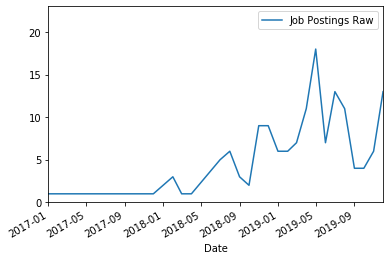

In [42]:
df_to_plot = skills_df.loc[skills_df.Skill == 'apache kafka', ['Date', 'Job Postings Raw']].groupby('Date').sum()
df_to_plot.plot()
plt.ylim([0, df_to_plot['Job Postings Raw'].max() + 5])
plt.show()

## Looking at the distributions of computed quantities

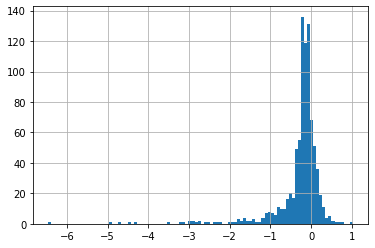

In [43]:
skill_trends[1].Slope.hist(bins=100)
#plt.yscale('log')

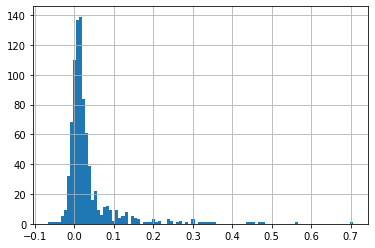

In [44]:
skill_trends[1].Acceleration.hist(bins=100)
#plt.yscale('log')

In [45]:
skill_trends[2].Slope.quantile(.8), \
            skill_trends[2].Slope.quantile(.9), skill_trends[2].Slope.mean() 

(0.6658371553436462, 1.3965327913163206, 0.42701938686225266)

Interestingly, as this plot and the summary statistics show, the Slope values are way more skewed to the right here, and the Generalised Normals that we had used before will fail.

In [46]:
total_values

[4305, 9634, 17411, 27045, 13939, 31350]

In [47]:
period_i = 3
raw_proportions = get_period_of_time(skills_df, start_and_end_dates[period_i][0], start_and_end_dates[period_i][1])\
                [['Skill', 'Job Postings Raw']].groupby('Skill').sum() / total_values[period_i]

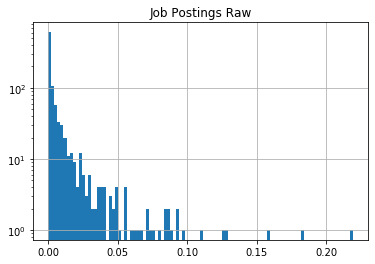

In [48]:
raw_proportions.hist(bins = 100)
plt.yscale('log')

In [49]:
raw_proportions.describe()

,Job Postings Raw
count,969.000000
mean,0.006877
std,0.017887
min,0.000037
25%,0.000259
50%,0.001109
75%,0.004881
max,0.219079


In [50]:
raw_proportions.quantile(.5), raw_proportions.quantile(.9)

(Job Postings Raw    0.001109
 Name: 0.5, dtype: float64, Job Postings Raw    0.016898
 Name: 0.9, dtype: float64)

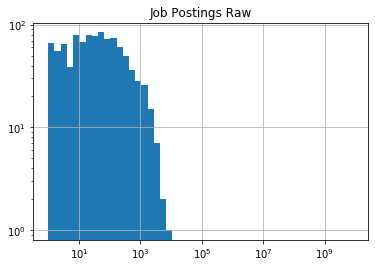

In [51]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(20000), 50))
plt.yscale('log')
plt.xscale('log')

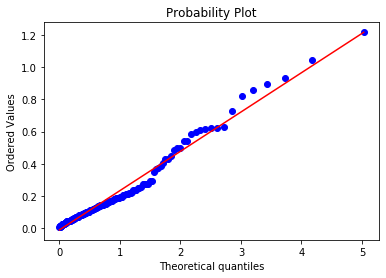

In [52]:
probplot(skill_trends[0].loc[skill_trends[0].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.8), fit=True, plot=plt)
plt.show()

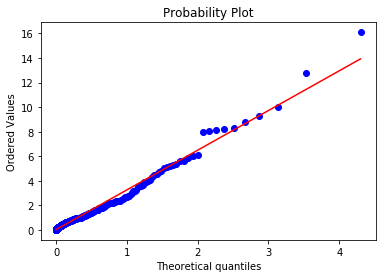

In [53]:
probplot(skill_trends[2].loc[skill_trends[2].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.3), fit=True, plot=plt)
plt.show()

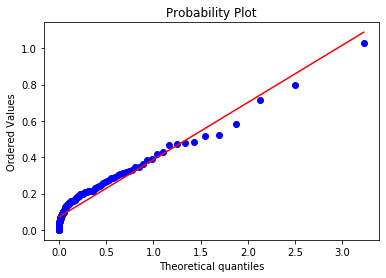

In [54]:
probplot(skill_trends[1].loc[skill_trends[1].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.25), fit=True, plot=plt)
plt.show()

Generally, it's safe to say that the slope values generally follow two back to back Gamma distributions, one for the positives and one for the negatives. We don't really care about the negatives (because they're the _declining_ skills, while we're only interested in the growing skills), meaning that we can just discard the negatives and fit a Gamma to the positives.

The mean and variance of this distribution are equal to the shape parameter, which makes it very interesting: it's a distribution with faster than exponential decay, meaning that even the mean can be pretty restrictive!

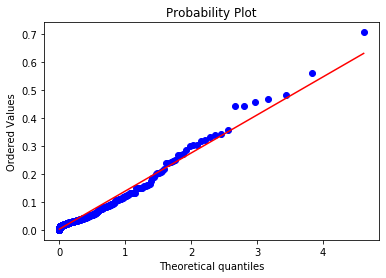

In [55]:
probplot(skill_trends[1].loc[skill_trends[1].Acceleration > 0].Acceleration.values, dist=stats.gamma, 
         sparams=(.3), fit=True, plot=plt)
plt.show()

The acceleration is a Gamma if we remove the very extreme outliers, but with _extremely low_ shape parameters.

((array([1.76589525e-32, 1.25366120e-28, 1.33053641e-26, 3.16269281e-25,
         3.49467921e-24, 2.42116229e-23, 1.22467014e-22, 4.93918332e-22,
         1.67910315e-21, 4.99464370e-21, 1.33462259e-20, 3.26578322e-20,
         7.42468728e-20, 1.58593004e-19, 3.21092049e-19, 6.20558057e-19,
         1.15143862e-18, 2.06094368e-18, 3.57255864e-18, 6.01772112e-18,
         9.87778994e-18, 1.58388267e-17, 2.48621482e-17, 3.82740937e-17,
         5.78789859e-17, 8.60998558e-17, 1.26152144e-16, 1.82256297e-16,
         2.59895930e-16, 3.66129077e-16, 5.09960907e-16, 7.02787279e-16,
         9.58919510e-16, 1.29620186e-15, 1.73673440e-15, 2.30771515e-15,
         3.04241685e-15, 3.98131495e-15, 5.17338499e-15, 6.67758931e-15,
         8.56457442e-15, 1.09186022e-14, 1.38397405e-14, 1.74463392e-14,
         2.18778226e-14, 2.72978275e-14, 3.38977221e-14, 4.19005410e-14,
         5.15653751e-14, 6.31922572e-14, 7.71275874e-14, 9.37701454e-14,
         1.13577738e-13, 1.37074536e-13, 1.64859156

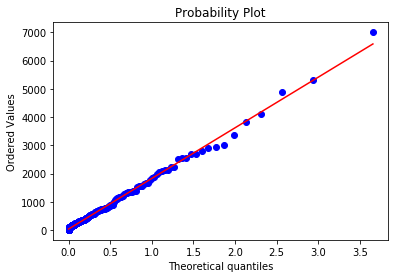

In [56]:
probplot(skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()['Job Postings Raw'].values, 
         dist=stats.gamma, 
         sparams=(.1), fit=True, plot=plt)

## Exported list of skills

In [61]:
df_export, set_export = get_skills_by_threshold(skill_trends[5], total_values[5], 'HybridScore', [.9,.8,.7], 
                                       pop_lower_bounds=[0], pop_upper_bounds=[0.8, .85, 0.9], sample=15)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_export)

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore,Params,Set#
0,react.js,0.164167,0.194641,0.005469,2.563673,375,0.434816,"(0.9, 0, 0.9)",3
1,relational database,0.048777,0.225280,0.011286,3.119214,442,0.459573,"(0.9, 0, 0.9)",3
2,test automation,0.353505,-1.110829,0.001601,2.868035,438,0.442881,"(0.9, 0, 0.9)",3
3,data science,0.247885,-0.401434,0.004246,3.074336,440,0.443452,"(0.9, 0, 0.9)",3
4,tableau,0.087819,1.080512,0.008377,2.280664,507,0.443018,"(0.9, 0, 0.9)",3
5,docker,0.184369,0.007184,0.007816,2.838533,473,0.461586,"(0.9, 0, 0.9)",3
6,adobe illustrator,-0.217181,2.694679,0.019695,2.790540,515,0.462840,"(0.9, 0, 0.9)",3
7,enterprise systems,-0.015221,1.805702,0.010414,2.482089,448,0.435562,"(0.9, 0, 0.9)",3
8,nosql,-0.100188,2.557997,0.012644,2.434977,420,0.433502,"(0.9, 0, 0.9)",3
9,information technology infrastructure library,0.002406,1.615606,0.012486,2.486396,502,0.458516,"(0.9, 0, 0.9)",3


In [64]:
df_export.to_csv('survey_export.csv')

In [63]:
for x in df_export.Skill.values.tolist():
    print(x)

react.js
relational database
test automation
data science
tableau
docker
adobe illustrator
enterprise systems
nosql
information technology infrastructure library
spring framework
root cause analysis
redis
apache subversion (svn)
animation
waterfall model
scala
google analytics
enterprise web architecture
tensorflow
elasticsearch
business intelligence (bi) tools
sas
powershell
apache kafka
blockchain technology
apache hive
wireframes
fintech
knowledge management
system testing
ibm websphere
service oriented architecture
encryption/cryptography
proxy
network systems
ansible
google ads
pl/sql
mongodb
statistical analysis
microsoft office 365
infrastructure-as-a-service (iaas)
data/text mining
wide area network configuration
micro-services
shell scripts
hibernate
data quality control
vb
bootstrap
data visualisation
social media (youtube)
version control
github
market analysis
search engine optimization (seo)
nginx
vue.js
jsp (javaserver pages)
adobe marketo
mac os
mpls
data security
ruby o

In [72]:
skill_trends[5].reset_index().loc[skill_trends[5].reset_index().Skill.apply(lambda x: 'virtual' in x)]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
103,augmented/virtual reality,-0.027615,-0.096381,0.002530,4.618235,68,0.358839
666,oracle vm virtualbox,-0.031536,-0.377844,0.000962,-1.189804,9,0.342541
928,virtual design construction,-0.077512,-0.083086,0.002050,-0.378800,6,0.341326
929,virtual desktop infrastructure (vdi),-0.031728,-0.002552,0.001741,10.836956,49,0.350121
930,virtual private network,0.170352,2.208847,0.001863,1.897464,431,0.401793
931,virtualization technology,0.903954,0.052830,-0.006987,1.895443,1335,0.476027


In [120]:
skill_trends[5].sort_values('HybridScore', ascending=False).tail(215)

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
Skill,,,,,,
loopback,-0.028452,-0.396812,0.000580,-0.072515,2,0.339564
enterprise content management system (ecm),0.007767,-0.466137,-0.000352,-0.817542,12,0.339557
sparql,0.015709,-0.511551,-0.000557,-0.901948,13,0.339521
screaming frog (seo),-0.056530,-0.208608,0.001308,-0.072515,2,0.339508
data center infrastructure management,-0.002185,-0.190678,-0.000106,-1.520052,23,0.339481
...,...,...,...,...,...,...
sun solaris,-0.070571,0.666991,0.000971,-6.100021,26,0.332579
ado.net,-0.066084,0.964797,0.000757,11.142254,43,0.331634
macromedia dreamweaver,-0.074839,0.565246,0.000947,-2.037697,19,0.331236


How would our method distinguish between skills that seem emerging in _this market_ vis a vis the skills that are _globally_ emerging? I think we can't do that unless we have some data on that global market (so basically it'd be great if we could have BGT back, I guess).

In [55]:
total_values[5] * 0.02

627.0

In [56]:
skill_trends[5].loc[skill_trends[5]['Job Postings Raw'] > total_values[5] * 0.02]

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
Skill,,,,,,
.net,-0.265641,11.610562,0.024407,2.122533,1307,0.488084
account management,1.574859,-1.238655,-0.012983,1.919031,1678,0.539796
adobe photoshop,-0.318786,6.159592,0.023746,2.431223,740,0.468202
amazon web services,0.409195,1.909694,0.018199,2.388303,1340,0.606052
android,-0.258310,7.686803,0.018881,2.452571,823,0.444928
...,...,...,...,...,...,...
user research,0.632638,7.305194,0.028611,2.317982,2221,0.740114
virtualization technology,0.903954,0.052830,-0.006987,1.895443,1335,0.476027
vmware,0.623402,1.780735,-0.004282,1.836372,1083,0.444726


## Analysis with companies

### Loading CBI data

In [57]:
cbi_sg = pd.read_csv('/Users/ramtinyazdanian/Downloads/CB_Insights_Search_Results-3.csv')

In [58]:
cbi_sg

,Company,URL,Company Description,All Investors,Total Funding,Sector,Industry,Sub-Industry,Country,State,City,Mosaic Overall Score,Mosaic Momentum Score,Mosaic Money Score,Mosaic Market Score
0,Ninja Van,http://www.ninjavan.co,Ninja Van offers next day deliveries for e-com...,Ace Capital;B Capital Group;Bangkok Bank;Carme...,398.50,Internet,Internet Software & Services,Supply Chain & Logistics,Singapore,NaN,NaN,890,840.0,980.0,820
1,NIUM,http://www.nium.com,"NIUM is a Singapore-based, cross-border paymen...",Atinum Investment;Beacon Venture Capital;BRI V...,59.00,Internet,Internet Software & Services,Payments,Singapore,NaN,Singapore,870,840.0,880.0,910
2,Moglix,http://www.moglix.com,Moglix is an Asia-based B2B commerce company i...,Accel;Composite Capital Partners;InnoVen Capit...,100.71,Internet,eCommerce,Marketplace,Singapore,NaN,NaN,850,850.0,870.0,780
3,AnyMind Group,http://www.anymindgroup.com,AnyMind Group aims to power businesses and pro...,Dream Incubator;Gunosy;Hisanori Watanabe;JAFCO...,62.30,Internet,Internet Software & Services,"Advertising, Sales & Marketing",Singapore,NaN,NaN,850,810.0,910.0,810
4,Doctor Anywhere,http://www.doctoranywhere.com,Doctor Anywhere is a Singapore-based telehealt...,EDBI;IHH Healthcare Berhad;Kamet Capital Partn...,31.10,Internet,Internet Software & Services,Healthcare,Singapore,NaN,Singapore,840,760.0,900.0,870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Team Flash,http://www.teamflash.gg,Team Flash is a Singapore-headquartered esport...,Octava;Reddentes Sports,1.50,Internet,Internet Software & Services,Sports,Singapore,NaN,NaN,480,460.0,510.0,460
272,Smarten Spaces,http://www.smartenspaces.com,Smarten Spaces offers workspace management sol...,Microsoft ScaleUp;Symphony,8.81,Internet,Internet Software & Services,Operating Systems & Utility,Singapore,NaN,NaN,480,NaN,750.0,220
273,QuantShip,http://www.quantship.ai,QuantShip provides AI-powered predictive analy...,Entrepreneur First;Techstars,0.20,Internet,Internet Software & Services,"Business Intelligence, Analytics & Performance...",Singapore,NaN,NaN,480,NaN,430.0,840
274,Global eTrade Services,http://www.globaletrade.services,Global eTrade Services is a CrimsonLogic subsi...,NaN,NaN,Internet,Internet Software & Services,Data & Document Management,Singapore,NaN,NaN,480,480.0,NaN,760


In [59]:
len(skills_df.Company.unique())

2264

In [60]:
def get_all_related_companies(df, company_list):
    results = list()
    print('Companies to get:')
    print(company_list)
    for company in company_list:
        results.extend(df.loc[df.Company.apply(lambda x: company.lower() in x.lower())].\
                                               Company.unique().tolist())
    print('Companies retrieved:')
    print(results)
    return results

In [61]:
company_totals[['Company', 'Total']].groupby('Company').sum().\
                                sort_values('Total', ascending=False).head(30)

,Total
Company,
ST Electronics (Info-comm Systems) Pte Ltd,1831
Facebook,1363
IHIS - Integrated Health Information Systems Pte Ltd,944
Cisco Systems,786
Autodesk,756
GOOGLE ASIA PACIFIC PTE. LTD.,666
VMware,505
M1 Limited,455
Amadeus IT Group SA,453


### HITS example and sanity checks

In [62]:
hits_skills, hits_companies = hits_on_companies(get_period_of_time(skills_df, 
                                       start_and_end_dates[5][0], start_and_end_dates[5][1]), 
                    emerging_skills[5].sort_values('HybridScore', ascending=False).Skill.values.tolist())

### HITS authority scores

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hits_skills.sort_values('Score', ascending=False))

,Skill,Score
53,mongodb,0.169682
73,restful api,0.161221
47,kubernetes,0.160482
19,data quality control,0.160398
85,soap,0.155585
65,postgresql,0.155451
20,data structure,0.154640
2,ansible,0.153336
82,shell scripts,0.146442
21,data visualisation,0.140551


### HITS hub scores

In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hits_companies.sort_values('Score', ascending=False))

,Company,Score
547,IHIS - Integrated Health Information Systems P...,0.196531
149,Autodesk,0.195097
495,HCL SINGAPORE PTE. LTD.,0.189308
824,Optimum Solutions (S) Pte Ltd,0.186647
675,Luxoft,0.186200
260,Cisco Systems,0.179908
986,ST Electronics (Info-comm Systems) Pte Ltd,0.162873
676,M1 Limited,0.156707
463,GOOGLE ASIA PACIFIC PTE. LTD.,0.154516
662,Lazada,0.148244


In [318]:
#set_of_companies = get_all_related_companies(skills_df, ['Amazon', 'Google', 'Microsoft', 'Facebook'])
# set_of_companies = company_totals[['Company', 'Total']].groupby('Company').sum().\
#                                 sort_values('Total', ascending=False).head(20).index.values.tolist()
# set_of_companies = get_all_related_companies(skills_df, cbi_sg.sort_values('Mosaic Overall Score', ascending=False).\
#                                              head(50).Company.values.tolist())
# set_of_companies = get_all_related_companies(skills_df, cbi_sg.sort_values('Mosaic Overall Score', ascending=False).\
#                                              head(150).Company.values.tolist())
set_of_companies = hits_companies.sort_values('Score', ascending=False).head(20).Company.values.tolist()


companies_skills = get_set_of_companies(skills_df, set_of_companies)
companies_specialised_skill_trends = [logsum_trend_slope_wrapper(companies_skills, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  compute_total_log_mean(
                                              companies_skills)) 
                                      for i in range(len(start_and_end_dates))]

Start: 2017-01-01
End: 2018-01-01
Number of skills: 374
            Slope   Intercept  Acceleration   Spikiness
count  374.000000  374.000000    374.000000  374.000000
mean    -0.028072   -2.280181      0.008924    0.630158
std      0.220668    0.917106      0.017952    2.531241
min     -1.185767   -3.285796     -0.059252  -28.774100
25%     -0.083742   -2.869593      0.001004    0.773666
50%     -0.000166   -2.616963      0.004092    0.847409
75%      0.054087   -1.894554      0.013090    0.885465
max      1.071230    1.900040      0.110515   18.005037
Start: 2018-01-01
End: 2019-01-01
Number of skills: 617
            Slope   Intercept  Acceleration   Spikiness
count  617.000000  617.000000    617.000000  617.000000
mean    -0.080205   -1.499817      0.011520    1.459399
std      0.317163    1.894611      0.026685   14.733495
min     -1.468588   -4.367224     -0.082364  -19.207440
25%     -0.165728   -2.482585      0.003521    0.644557
50%     -0.084553   -2.235426      0.010798    0

In [319]:
set_of_companies

['IHIS - Integrated Health Information Systems Pte Ltd',
 'Autodesk',
 'HCL SINGAPORE PTE. LTD.',
 'Optimum Solutions (S) Pte Ltd',
 'Luxoft',
 'Cisco Systems',
 'ST Electronics (Info-comm Systems) Pte Ltd',
 'M1 Limited',
 'GOOGLE ASIA PACIFIC PTE. LTD.',
 'Lazada',
 'Facebook',
 'Equinix',
 'AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED',
 'TESCOM (SINGAPORE) SOFTWARE SYSTEMS TESTING PTE LTD.',
 'Google',
 'VMware',
 'F5 Networks',
 'ERP21 PTE LTD',
 'EQUINIX ASIA PACIFIC PTE. LTD.',
 'SMARTSOFT PTE. LTD.']

In [320]:
for skill_trend_df in companies_specialised_skill_trends:
    skill_trend_df['HybridScore'] = get_hybrid_score(skill_trend_df, 
                                 ['Slope', 'Acceleration'], weights=[1,1])

In [473]:
companies_emerging_spec_skills = [threshold_logsum_trends_simple(
        companies_specialised_skill_trends[i], col='HybridScore', 
              only_positives=True,
              col_percentile_thresh=.7, col_std_thresh=0, pop_lower=0.001, pop_upper=0.01,
        total=get_period_of_time(compute_total_values(companies_skills),
        start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0])
                        for i in range(len(companies_specialised_skill_trends))]

In [474]:
[compute_prec_recall(companies_emerging_spec_skills[i], emerging_skills[i]) 
                     for i in range(len(companies_emerging_spec_skills))]


Correctly predicted skills:
{'storage area network', 'ibm websphere', 'soapui', 'esx', 'digital platforms', 'social media (youtube)', 'implementation plans', 'xsl', 'hibernate', 'vsphere', 'enterprise systems', 'benchmarking'}

Number of correctly predicted skills, all predicted positives, and true positives:
12 23 131

Correctly predicted skills:
{'java persistence api (jpa)', 'objective c', 'matlab', 'gamification', 'adobe analytics', 'microsoft visio', 'full stack development', 'social media (whatsapp)', 'automation testing', 'enterprise web architecture', 'interaction design (ixd)', 'aml/cft', 'cryptocurrency', 'restful api', 'service management', 'it operations management (itom)', 'hris', 'sap hana', 'openshift', 'google adwords', 'mac os', 'resource management', 'publishing', 'spss', 'robotic process automation', 'microsoft office 365', 'postgresql', 'saml', 'mpls', 'financial analysis', 'is-is', 'gaap', 'elk stack', 'dynamic host configuration protocol', 'mobile technology', 'p

[(0.5217391304347826, 0.0916030534351145, 0.15584415584415584),
 (0.6029411764705882, 0.35344827586206895, 0.44565217391304346),
 (0.4807692307692308, 0.3816793893129771, 0.4255319148936171),
 (0.38, 0.4418604651162791, 0.40860215053763443),
 (0.5217391304347826, 0.48, 0.4999999999999999),
 (0.4588235294117647, 0.52, 0.48750000000000004)]

In [475]:
[compute_prec_recall(companies_emerging_spec_skills[i], emerging_skills[i]) 
                     for i in range(len(companies_emerging_spec_skills))]


Correctly predicted skills:
{'storage area network', 'ibm websphere', 'soapui', 'esx', 'digital platforms', 'social media (youtube)', 'implementation plans', 'xsl', 'hibernate', 'vsphere', 'enterprise systems', 'benchmarking'}

Number of correctly predicted skills, all predicted positives, and true positives:
12 23 131

Correctly predicted skills:
{'java persistence api (jpa)', 'objective c', 'matlab', 'gamification', 'adobe analytics', 'microsoft visio', 'full stack development', 'social media (whatsapp)', 'automation testing', 'enterprise web architecture', 'interaction design (ixd)', 'aml/cft', 'cryptocurrency', 'restful api', 'service management', 'it operations management (itom)', 'hris', 'sap hana', 'openshift', 'google adwords', 'mac os', 'resource management', 'publishing', 'spss', 'robotic process automation', 'microsoft office 365', 'postgresql', 'saml', 'mpls', 'financial analysis', 'is-is', 'gaap', 'elk stack', 'dynamic host configuration protocol', 'mobile technology', 'p

[(0.5217391304347826, 0.0916030534351145, 0.15584415584415584),
 (0.6029411764705882, 0.35344827586206895, 0.44565217391304346),
 (0.4807692307692308, 0.3816793893129771, 0.4255319148936171),
 (0.38, 0.4418604651162791, 0.40860215053763443),
 (0.5217391304347826, 0.48, 0.4999999999999999),
 (0.4588235294117647, 0.52, 0.48750000000000004)]

In [476]:
[compute_prec_recall(companies_emerging_spec_skills[i], ground_truth_base) 
                     for i in range(len(companies_emerging_spec_skills))]


Correctly predicted skills:
set()

Number of correctly predicted skills, all predicted positives, and true positives:
0 23 24

Correctly predicted skills:
{'cryptocurrency'}

Number of correctly predicted skills, all predicted positives, and true positives:
1 68 24

Correctly predicted skills:
{'encryption/cryptography', 'keras', 'apache kafka'}

Number of correctly predicted skills, all predicted positives, and true positives:
3 104 24

Correctly predicted skills:
{'fintech', 'encryption/cryptography', 'apache kafka', 'blockchain technology', 'google go programming language', 'predictive modelling', 'predictive analytics', 'tensorflow'}

Number of correctly predicted skills, all predicted positives, and true positives:
8 100 24

Correctly predicted skills:
{'data visualisation', 'encryption/cryptography', 'apache kafka', 'google go programming language', 'tensorflow'}

Number of correctly predicted skills, all predicted positives, and true positives:
5 69 24

Correctly predicted skil

[(0.0, 0.0, 0),
 (0.014705882352941176, 0.041666666666666664, 0.02173913043478261),
 (0.028846153846153848, 0.125, 0.046875),
 (0.08, 0.3333333333333333, 0.12903225806451613),
 (0.07246376811594203, 0.20833333333333334, 0.10752688172043011),
 (0.058823529411764705, 0.20833333333333334, 0.09174311926605505)]

### Actual predictions

In [74]:
start_and_end_dates

[(numpy.datetime64('2017-01-01'), numpy.datetime64('2018-01-01')),
 (numpy.datetime64('2018-01-01'), numpy.datetime64('2019-01-01')),
 (numpy.datetime64('2019-01-01'), numpy.datetime64('2020-01-01')),
 (numpy.datetime64('2018-01-01'), numpy.datetime64('2020-01-01')),
 (numpy.datetime64('2017-01-01'), numpy.datetime64('2019-01-01')),
 (numpy.datetime64('2017-01-01'), numpy.datetime64('2020-01-01'))]

In [75]:
[compute_prec_recall(companies_emerging_spec_skills[0], emerging_skills[1]), 
 compute_prec_recall(companies_emerging_spec_skills[1], emerging_skills[2]), 
 compute_prec_recall(companies_emerging_spec_skills[0], emerging_skills[3])]


Correctly predicted skills:
{'swift', 'benchmarking', 'social media (youtube)'}

Number of correctly predicted skills, all predicted positives, and true positives:
3 19 98

Correctly predicted skills:
{'user data analytics', 'source code', 'elk stack', 'facebook ads', 'matlab', 'service management', 'google analytics', 'robotic process automation', 'ospf', 'full stack development', 'it operations management (itom)', 'hris', 'microsoft office 365', 'social media (whatsapp)', 'enterprise web architecture', 'mpls', 'openshift'}

Number of correctly predicted skills, all predicted positives, and true positives:
17 62 105

Correctly predicted skills:
set()

Number of correctly predicted skills, all predicted positives, and true positives:
0 19 104


[(0.15789473684210525, 0.030612244897959183, 0.05128205128205128),
 (0.27419354838709675, 0.1619047619047619, 0.20359281437125748),
 (0.0, 0.0, 0)]

In [76]:
[compute_prec_recall(companies_emerging_spec_skills[0], emerging_skills[1]), 
 compute_prec_recall(companies_emerging_spec_skills[1], emerging_skills[2]), 
 compute_prec_recall(companies_emerging_spec_skills[0], emerging_skills[3])]


Correctly predicted skills:
{'swift', 'benchmarking', 'social media (youtube)'}

Number of correctly predicted skills, all predicted positives, and true positives:
3 19 98

Correctly predicted skills:
{'user data analytics', 'source code', 'elk stack', 'facebook ads', 'matlab', 'service management', 'google analytics', 'robotic process automation', 'ospf', 'full stack development', 'it operations management (itom)', 'hris', 'microsoft office 365', 'social media (whatsapp)', 'enterprise web architecture', 'mpls', 'openshift'}

Number of correctly predicted skills, all predicted positives, and true positives:
17 62 105

Correctly predicted skills:
set()

Number of correctly predicted skills, all predicted positives, and true positives:
0 19 104


[(0.15789473684210525, 0.030612244897959183, 0.05128205128205128),
 (0.27419354838709675, 0.1619047619047619, 0.20359281437125748),
 (0.0, 0.0, 0)]

In [77]:
companies_emerging_spec_skills[1]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
0,active directory federation services (adfs),-0.107463,-2.501204,0.013942,0.781909,4,0.748495
1,adobe analytics,-0.294322,-2.020957,0.031391,0.683569,9,0.753479
2,ajax,-0.170449,-1.849434,0.022474,0.323530,15,0.758584
3,api management system,-0.337249,-1.990392,0.035271,0.539881,7,0.753577
4,artificial intelligence,-0.202821,-1.395065,0.029490,-0.442692,25,0.771076
...,...,...,...,...,...,...,...
57,swift,-0.006683,-1.598371,0.007872,0.313526,26,0.754168
58,syslog protocols,-0.186524,-2.287764,0.019556,0.744311,5,0.745933
59,togaf,-0.126306,-2.030408,0.014785,0.771189,10,0.746447
60,user data analytics,-0.254729,-2.188795,0.027113,0.771912,4,0.751132


# Analysing company results side by side

In [121]:
n = 30
# Companies obtained using HITS with emerging skills as seed set
hits_all_data = [get_top_n_companies_from_hits(get_period_of_time(skills_df, 
                                       start_and_end_dates[i][0], start_and_end_dates[i][1]), emerging_skills[i],
                                              n = n)
                for i in range(len(start_and_end_dates))]
hits_top_companies = [x[0] for x in hits_all_data]

# Companies with the most ads in each period
pop_top_companies = [get_period_of_time(company_totals, 
            start_and_end_dates[i][0], start_and_end_dates[i][1])[['Company', 'Total']].groupby('Company').sum().\
                                sort_values('Total', ascending=False).head(n).index.values.tolist()
                    for i in range(len(start_and_end_dates))]


In [122]:
hits_top_company_emerging_skills = \
            [company_emerging_skill_wrapper(skills_df, hits_top_companies[i], start_and_end_dates)[0]
            for i in range(len(hits_top_companies))]
pop_top_company_emerging_skills = \
            [company_emerging_skill_wrapper(skills_df, pop_top_companies[i], start_and_end_dates)[0]
            for i in range(len(pop_top_companies))]

Start: 2017-01-01
End: 2018-01-01
Number of skills: 499
            Slope   Intercept  Acceleration   Spikiness
count  499.000000  499.000000    499.000000  499.000000
mean    -0.083099   -0.917660      0.012873    0.865324
std      0.330502    1.417848      0.030940    2.173766
min     -1.601875   -2.592919     -0.071702  -21.735994
25%     -0.151447   -1.711785     -0.003504    0.569713
50%     -0.014751   -1.317247      0.002831    0.874403
75%      0.080485   -0.644076      0.019503    0.900313
max      1.069701   10.038881      0.202896   19.039184
Start: 2018-01-01
End: 2019-01-01
Number of skills: 599
            Slope   Intercept  Acceleration     Spikiness
count  599.000000  599.000000    599.000000    599.000000
mean    -0.009887   -0.746683      0.000012    -74.053834
std      0.406751    2.066755      0.032911   1826.100131
min     -1.415932   -3.434824     -0.217000 -44692.192236
25%     -0.221513   -1.688439     -0.009065      0.506211
50%     -0.118030   -1.469861      0

            Slope   Intercept  Acceleration   Spikiness
count  769.000000  769.000000    769.000000  769.000000
mean     0.106700   -2.178058     -0.001686    0.807382
std      0.267831    1.356850      0.008442   10.036663
min     -1.116718   -6.819534     -0.052465 -174.148351
25%     -0.010468   -2.927517     -0.004514    0.443830
50%      0.076930   -2.487157     -0.002707    0.786496
75%      0.124905   -1.846634      0.001909    0.803137
max      1.982095    8.035435      0.052012  160.930876
Start: 2017-01-01
End: 2019-01-01
Number of skills: 634
            Slope   Intercept  Acceleration   Spikiness
count  634.000000  634.000000    634.000000  634.000000
mean    -0.050071   -2.138582      0.004240    0.590771
std      0.164569    0.893336      0.007306    4.361890
min     -0.777074   -3.268376     -0.023607  -28.901918
25%     -0.122218   -2.711649      0.000222    0.340311
50%     -0.043361   -2.352308      0.002628    0.766188
75%      0.017943   -1.894874      0.006673    0

            Slope   Intercept  Acceleration   Spikiness
count  382.000000  382.000000    382.000000  382.000000
mean    -0.048501   -2.225326      0.011809    0.929851
std      0.247745    1.014342      0.020759   10.155316
min     -1.993340   -3.257486     -0.049156  -83.401951
25%     -0.102477   -2.880878      0.002657    0.790344
50%     -0.014112   -2.602887      0.006710    0.804469
75%      0.048073   -1.776443      0.015335    0.850043
max      0.982558    4.306922      0.178499  173.854719
Start: 2018-01-01
End: 2019-01-01
Number of skills: 644
            Slope   Intercept  Acceleration    Spikiness
count  644.000000  644.000000    644.000000   644.000000
mean    -0.189632   -1.173995      0.021560    -1.946616
std      0.390165    2.337499      0.035819    50.034981
min     -2.618473   -4.261347     -0.076048 -1222.272296
25%     -0.277216   -2.427675      0.006981     0.603069
50%     -0.122010   -2.101393      0.012670     0.779561
75%     -0.051053   -0.981793      0.0287

            Slope   Intercept  Acceleration   Spikiness
count  731.000000  731.000000    731.000000  731.000000
mean    -0.025124   -0.606902      0.001093    0.733213
std      0.256740    3.351185      0.010626   22.265276
min     -1.668451   -4.136750     -0.040817 -343.429918
25%     -0.082927   -2.221909     -0.003363    0.337518
50%      0.027967   -1.841764     -0.001785    0.608724
75%      0.070551   -0.561354      0.003480    0.690753
max      1.132173   27.029377      0.072913  333.744927
Start: 2017-01-01
End: 2019-01-01
Number of skills: 675
            Slope   Intercept  Acceleration   Spikiness
count  675.000000  675.000000    675.000000  675.000000
mean     0.002414   -1.662793      0.002738    0.762494
std      0.283633    0.920169      0.010208   14.284491
min     -0.878646   -5.625180     -0.039249 -170.895986
25%     -0.132108   -2.211093     -0.002680    0.151835
50%     -0.016739   -1.795466      0.001455    0.693787
75%      0.069706   -1.294785      0.007528    0

Number of skills: 482
            Slope   Intercept  Acceleration   Spikiness
count  482.000000  482.000000    482.000000  482.000000
mean    -0.130108   -1.003020      0.015991    0.717104
std      0.315764    1.486647      0.029607   12.208469
min     -2.210889   -2.677641     -0.056599 -147.859151
25%     -0.195134   -1.853589      0.004204    0.609521
50%     -0.086367   -1.622213      0.010520    0.792562
75%     -0.011169   -0.714448      0.020519    0.827363
max      1.061976    8.196626      0.202791  175.074786
Start: 2018-01-01
End: 2019-01-01
Number of skills: 661
            Slope   Intercept  Acceleration   Spikiness
count  661.000000  661.000000    661.000000  661.000000
mean     0.061084   -0.738254     -0.003229    1.241583
std      0.497779    2.425827      0.038679   17.856865
min     -1.587406   -3.774174     -0.230016 -248.433171
25%     -0.180203   -1.859233     -0.013277    0.459727
50%     -0.042101   -1.547046      0.001840    0.715857
75%      0.170167   -0.668

## Comparisons and predictions

The valid comparisons are:

* Comparing each set of companies' emerging skills to the ground truth set, mostly valid for the company's emerging skills in its own time period and the one after, but can be computed for any period.
* Comparing each set of companies' emerging skills to the emerging skills for the next time period (e.g. 2017 HITS companies to 2018 base, or 2018 POP companies to 2019 base) and to emerging skills for its own.
* Comparing the HITS companies to the POP companies.

### Number 1: Ground truth comparisons

### For each company set's own period:

HITS:

In [124]:
[compute_prec_recall(hits_top_company_emerging_skills[i][i], ground_truth_base) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'docker', 'encryption/cryptography'}

Number of correctly predicted skills, all predicted positives, and true positives:
2 75 24

Correctly predicted skills:
{'data visualisation', 'fintech', 'apache kafka', 'graphql', 'micro-services', 'cryptocurrency', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
7 109 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'tensorflow', 'apache kafka', 'blockchain technology', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
7 115 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'tensorflow', 'docker', 'predictive analytics', 'blockchain technology', 'encryption/cryptography', 'micro-services'}

Number of correctly predicted skills, all predicted positives, and true positives:
9 124 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'docker', 'g

[(0.02666666666666667, 0.08333333333333333, 0.0404040404040404),
 (0.06422018348623854, 0.2916666666666667, 0.10526315789473685),
 (0.06086956521739131, 0.2916666666666667, 0.10071942446043165),
 (0.07258064516129033, 0.375, 0.12162162162162164),
 (0.06837606837606838, 0.3333333333333333, 0.11347517730496454),
 (0.08064516129032258, 0.4166666666666667, 0.13513513513513511)]

POP (raw period ad count)

In [125]:
[compute_prec_recall(pop_top_company_emerging_skills[i][i], ground_truth_base) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'encryption/cryptography', 'salesforce'}

Number of correctly predicted skills, all predicted positives, and true positives:
2 75 24

Correctly predicted skills:
{'hadoop distributed file system', 'micro-services', 'fintech', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
4 93 24

Correctly predicted skills:
{'kubernetes', 'docker', 'deep learning', 'apache kafka', 'blockchain technology', 'encryption/cryptography', 'micro-services'}

Number of correctly predicted skills, all predicted positives, and true positives:
7 107 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'docker', 'predictive analytics', 'blockchain technology', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
8 122 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'docker', 'google go programming language', 'apache kafka', 'deep

[(0.02666666666666667, 0.08333333333333333, 0.0404040404040404),
 (0.043010752688172046, 0.16666666666666666, 0.06837606837606838),
 (0.06542056074766354, 0.2916666666666667, 0.10687022900763357),
 (0.06557377049180328, 0.3333333333333333, 0.1095890410958904),
 (0.07692307692307693, 0.375, 0.12765957446808512),
 (0.088, 0.4583333333333333, 0.14765100671140938)]

### For the period after (essentially, the predictive one)

HITS:

In [126]:
[compute_prec_recall(hits_top_company_emerging_skills[i][j], ground_truth_base) 
                     for i,j in [(0,1), (1,2), (0,3)]]


Correctly predicted skills:
{'apache kafka'}

Number of correctly predicted skills, all predicted positives, and true positives:
1 109 24

Correctly predicted skills:
{'tensorflow', 'docker', 'apache kafka', 'blockchain technology', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
6 103 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'tensorflow', 'deep learning', 'apache kafka', 'blockchain technology', 'encryption/cryptography', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
9 114 24


[(0.009174311926605505, 0.041666666666666664, 0.015037593984962407),
 (0.05825242718446602, 0.25, 0.09448818897637797),
 (0.07894736842105263, 0.375, 0.13043478260869565)]

POP:

In [127]:
[compute_prec_recall(pop_top_company_emerging_skills[i][j], ground_truth_base) 
                     for i,j in [(0,1), (1,2), (0,3)]]


Correctly predicted skills:
{'docker', 'apache kafka', 'micro-services', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
4 102 24

Correctly predicted skills:
{'kubernetes', 'docker', 'apache kafka', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
5 101 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'tensorflow', 'apache kafka', 'blockchain technology', 'encryption/cryptography', 'micro-services', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
8 104 24


[(0.0392156862745098, 0.16666666666666666, 0.06349206349206349),
 (0.04950495049504951, 0.20833333333333334, 0.08),
 (0.07692307692307693, 0.3333333333333333, 0.125)]

### For the whole period (2017-2020)

HITS:

In [129]:
[compute_prec_recall(hits_top_company_emerging_skills[i][5], ground_truth_base) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'kubernetes', 'data visualisation', 'tensorflow', 'google go programming language', 'apache kafka', 'predictive analytics', 'micro-services', 'blockchain technology', 'apache hive', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
10 120 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'docker', 'deep learning', 'apache kafka', 'micro-services', 'encryption/cryptography', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
8 116 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'tensorflow', 'docker', 'deep learning', 'apache kafka', 'micro-services', 'blockchain technology', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
10 119 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'tensorflow', 'docker', 'deep learning', 'apache kafka', 'mi

[(0.08333333333333333, 0.4166666666666667, 0.1388888888888889),
 (0.06896551724137931, 0.3333333333333333, 0.1142857142857143),
 (0.08403361344537816, 0.4166666666666667, 0.1398601398601399),
 (0.09243697478991597, 0.4583333333333333, 0.15384615384615385),
 (0.059322033898305086, 0.2916666666666667, 0.09859154929577464),
 (0.08064516129032258, 0.4166666666666667, 0.13513513513513511)]

POP:

In [130]:
[compute_prec_recall(pop_top_company_emerging_skills[i][5], ground_truth_base) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'kubernetes', 'data visualisation', 'tensorflow', 'docker', 'google go programming language', 'apache kafka', 'deep learning', 'micro-services', 'blockchain technology', 'encryption/cryptography', 'apache hive', 'keras'}

Number of correctly predicted skills, all predicted positives, and true positives:
12 114 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fintech', 'tensorflow', 'docker', 'deep learning', 'apache kafka', 'micro-services', 'encryption/cryptography', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
10 113 24

Correctly predicted skills:
{'data visualisation', 'tensorflow', 'docker', 'google go programming language', 'apache kafka', 'deep learning', 'micro-services', 'encryption/cryptography', 'apache hive'}

Number of correctly predicted skills, all predicted positives, and true positives:
9 115 24

Correctly predicted skills:
{'kubernetes', 'data visualisation', 'fint

[(0.10526315789473684, 0.5, 0.17391304347826086),
 (0.08849557522123894, 0.4166666666666667, 0.145985401459854),
 (0.0782608695652174, 0.375, 0.12949640287769787),
 (0.09243697478991597, 0.4583333333333333, 0.15384615384615385),
 (0.09016393442622951, 0.4583333333333333, 0.1506849315068493),
 (0.088, 0.4583333333333333, 0.14765100671140938)]

### Number 2: Base (whole market) emerging skill comparisons

### For each company set's own period:

HITS:

In [131]:
[compute_prec_recall(hits_top_company_emerging_skills[i][i], emerging_skills[i])
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'ospf', 'bgp (border gateway protocol)', 'microsoft hyper-v', 'voip', 'data center operations', 'oracle database', 'load balancer', 'software engineering', 'splunk', 'docker', 'centos', 'openstack', 'encryption/cryptography', 'j2ee', 'it service management', 'devops', 'application security design', 'knowledge management', 'ibm db2', 'it operations management (itom)', 'soapui', 'global positioning system', 'enterprise systems', 'mongodb', 'practical malware analysis', 'dynamic host configuration protocol', 'storage area network', 'nas infrastructure', 'autodesk', 'root cause analysis', 'jenkins', 'benchmarking', 'data loss prevention', 'information technology infrastructure library', 'middleware', 'ubuntu'}

Number of correctly predicted skills, all predicted positives, and true positives:
36 75 101

Correctly predicted skills:
{'powershell', 'saml', 'bgp (border gateway protocol)', 'relational database', 'ospf', 'infrastructure-as-a-service (iaas)', 'finte

[(0.48, 0.3564356435643564, 0.40909090909090906),
 (0.46788990825688076, 0.46788990825688076, 0.46788990825688076),
 (0.34782608695652173, 0.34782608695652173, 0.34782608695652173),
 (0.33064516129032256, 0.38317757009345793, 0.354978354978355),
 (0.48717948717948717, 0.5588235294117647, 0.5205479452054794),
 (0.4435483870967742, 0.5612244897959183, 0.49549549549549554)]

POP (raw period ad count)

In [132]:
[compute_prec_recall(pop_top_company_emerging_skills[i][i], emerging_skills[i]) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'laravel', 'microsoft hyper-v', 'voip', 'mvc framework', 'cloud infrastructure management', 'apache maven', 'oracle database', 'apache tomcat', 'geographic information system (gis)', 'software engineering', 'centos', 'hibernate', 'openstack', 'encryption/cryptography', 'system testing', 'j2ee', 'it service management', 'platform-as-a-service (paas)', 'application security design', 'software-as-a-service (saas)', 'ibm db2', 'perl', 'service oriented architecture', 'it operations management (itom)', 'soapui', 'github', 'enterprise systems', 'mobile application development', 'jira', 'dynamic host configuration protocol', 'nas infrastructure', 'autodesk', 'jenkins', 'benchmarking', 'data loss prevention', 'information technology infrastructure library', 'ubuntu', 'big data'}

Number of correctly predicted skills, all predicted positives, and true positives:
38 75 101

Correctly predicted skills:
{'powershell', 'ospf', 'bgp (border gateway protocol)', 'relation

[(0.5066666666666667, 0.37623762376237624, 0.4318181818181818),
 (0.4838709677419355, 0.41284403669724773, 0.4455445544554456),
 (0.29906542056074764, 0.2782608695652174, 0.2882882882882883),
 (0.3442622950819672, 0.3925233644859813, 0.3668122270742358),
 (0.47863247863247865, 0.5490196078431373, 0.5114155251141552),
 (0.424, 0.5408163265306123, 0.4753363228699552)]

### For the period after (essentially, the predictive one)

HITS:

In [133]:
[compute_prec_recall(hits_top_company_emerging_skills[i][j], emerging_skills[j]) 
                     for i,j in [(0,1), (1,2), (0,3)]]


Correctly predicted skills:
{'powershell', 'natural language processing (nlp)', 'bgp (border gateway protocol)', 'qlikview', 'ospf', 'infrastructure-as-a-service (iaas)', 'data wrangling', 'shell scripts', 'oracle database', 'mpls', 'ibm websphere', 'google analytics', 'data structure', 'publishing', 'enterprise web architecture', 'data quality control', 'test-driven development', 'platform-as-a-service (paas)', 'service management', 'market analysis', 'microsoft visio', 'apache kafka', 'vb', 'sas', 'mobile application development', 'jira', 'dynamic host configuration protocol', 'objective c', 'swift', 'soap', 'openshift', 'sdk'}

Number of correctly predicted skills, all predicted positives, and true positives:
32 109 109

Correctly predicted skills:
{'data wrangling', 'tensorflow', 'software development methodologies', 'wide area network configuration', 'cloud infrastructure management', 'source code', 'oracle database', 'mpls', 'confluence', 'tfs', 'human-computer interaction', 'sy

[(0.29357798165137616, 0.29357798165137616, 0.29357798165137616),
 (0.30097087378640774, 0.26956521739130435, 0.28440366972477066),
 (0.39473684210526316, 0.4205607476635514, 0.4072398190045249)]

POP:

In [134]:
[compute_prec_recall(pop_top_company_emerging_skills[i][j], emerging_skills[j]) 
                     for i,j in [(0,1), (1,2), (0,3)]]


Correctly predicted skills:
{'powershell', 'ospf', 'bgp (border gateway protocol)', 'qlikview', 'infrastructure-as-a-service (iaas)', 'scala', 'apache hive', 'oracle database', 'mpls', 'ibm websphere', 'google analytics', 'data structure', 'publishing', 'front-end development', 'enterprise web architecture', 'elk stack', 'data quality control', 'test-driven development', 'resource management', 'react.js', 'service oriented architecture', 'apache kafka', 'github', 'vb', 'mobile application development', 'jira', 'dynamic host configuration protocol', 'objective c', 'adobe phonegap', 'microsoft project', 'swift', 'soap', 'sdk', 'jboss', 'micro-services'}

Number of correctly predicted skills, all predicted positives, and true positives:
35 102 109

Correctly predicted skills:
{'data wrangling', 'software development methodologies', 'wide area network configuration', 'cloud infrastructure management', 'source code', 'oracle database', 'apache tomcat', 'geographic information system (gis)'

[(0.3431372549019608, 0.3211009174311927, 0.3317535545023697),
 (0.32673267326732675, 0.28695652173913044, 0.30555555555555564),
 (0.3942307692307692, 0.38317757009345793, 0.38862559241706157)]

### For the whole period (2017-2020)

HITS:

In [135]:
[compute_prec_recall(hits_top_company_emerging_skills[i][5], emerging_skills[5]) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'powershell', 'natural language processing (nlp)', 'bgp (border gateway protocol)', 'qlikview', 'tensorflow', 'shell scripts', 'scala', 'software quality', 'apache hive', 'elasticsearch', 'teradata', 'oracle database', 'splunk', 'mpls', 'ibm websphere', 'google analytics', 'confluence', 'google go programming language', 'openstack', 'front-end development', 'enterprise web architecture', 'data quality control', 'mac os', 'service management', 'cad (computer aided design)', 'apache kafka', 'github', 'ruby', 'bootstrap', 'blockchain technology', 'managed security services (mss)', 'practical malware analysis', 'waterfall model', 'spring boot framework', 'data migration', 'data visualisation', 'soap', 'openshift', 'apache subversion (svn)', 'financial analysis', 'terraform', 'microsoft office 365'}

Number of correctly predicted skills, all predicted positives, and true positives:
42 120 98

Correctly predicted skills:
{'powershell', 'data wrangling', 'bgp (bo

[(0.35, 0.42857142857142855, 0.3853211009174312),
 (0.3706896551724138, 0.4387755102040816, 0.40186915887850466),
 (0.44537815126050423, 0.5408163265306123, 0.4884792626728111),
 (0.42016806722689076, 0.5102040816326531, 0.46082949308755766),
 (0.3983050847457627, 0.47959183673469385, 0.4351851851851851),
 (0.4435483870967742, 0.5612244897959183, 0.49549549549549554)]

POP:

In [136]:
[compute_prec_recall(pop_top_company_emerging_skills[i][5], emerging_skills[5]) 
                     for i in range(len(hits_top_company_emerging_skills))]


Correctly predicted skills:
{'powershell', 'data wrangling', 'bgp (border gateway protocol)', 'qlikview', 'tensorflow', 'wordpress', 'software quality', 'source code', 'apache hive', 'elasticsearch', 'splunk', 'mpls', 'ibm websphere', 'google go programming language', 'content delivery network (cdn)', 'system testing', 'openstack', 'encryption/cryptography', 'front-end development', 'enterprise web architecture', 'proxy', 'postgresql', 'service oriented architecture', 'cad (computer aided design)', 'apache kafka', 'ruby', 'database optimisation', 'ansible', 'bootstrap', 'blockchain technology', 'practical malware analysis', 'ssl/tls', 'dynamic host configuration protocol', 'spring boot framework', 'waterfall model', 'data visualisation', 'search-engine marketing', 'network systems', 'soap', 'deep learning', 'parallel programming', 'terraform'}

Number of correctly predicted skills, all predicted positives, and true positives:
42 114 98

Correctly predicted skills:
{'bgp (border gatewa

[(0.3684210526315789, 0.42857142857142855, 0.39622641509433965),
 (0.34513274336283184, 0.3979591836734694, 0.3696682464454976),
 (0.4260869565217391, 0.5, 0.460093896713615),
 (0.42016806722689076, 0.5102040816326531, 0.46082949308755766),
 (0.4016393442622951, 0.5, 0.44545454545454544),
 (0.424, 0.5408163265306123, 0.4753363228699552)]

### Number 3: Comparing companies side by side

In [137]:
company_diffs_and_intersection = \
    [get_set_intersection_and_diff(hits_top_companies[i], pop_top_companies[i]) 
     for i in range(len(hits_top_companies))]
for i in range(len(company_diffs_and_intersection)):
    print()
    print(start_and_end_dates[i])
    print('\nIntersection:')
    print(company_diffs_and_intersection[i][0])
    print('\nHITS-only:')
    print(company_diffs_and_intersection[i][1])
    print('\nPOP-only:')
    print(company_diffs_and_intersection[i][2])


(numpy.datetime64('2017-01-01'), numpy.datetime64('2018-01-01'))

Intersection:
{'FireEye', 'Digisafe Pte Ltd', 'Liquidpay Singapore', 'LDR Pte Ltd', 'Red Hat', 'ENGIE ITS Pte Ltd', 'Arch Software Intelligence Pte. Ltd.', 'Circles Life', 'DataRobot', 'Denodo', 'Amazon Web Services', 'Circles.Life', 'Palo Alto Networks (S) Pte Ltd', 'Ishaan Informatics Pte Ltd', 'Luxoft', 'Indorse Pte Ltd', 'VMware'}

HITS-only:
{'NTC Integration Pte Ltd', 'Agilent Technologies Singapore (International) Pte Ltd', 'Qioptiq Singapore Pte Ltd', 'Westcon Group Pte Ltd', 'Onasus Pte Ltd', 'I-Access Solutions Pte Ltd', 'Aptsys Technology Solutions Pte Ltd', 'TeleChoice International Limited', 'Radiance Communications Pte Ltd', 'Institute of Medical Biology (IMB)', 'ST Electronics (Training & Simulation Systems) Pte Ltd', 'DuPont Company (Singapore) Pte Ltd', 'In Mind Cloud Pte Ltd', 'AiChat', 'ThunderQuote', 'Fleischhacker LLP', 'Singapore Immunology Network (SIgN)'}

POP-only:
{'HCL Insys Pte Ltd', 'Autodes

Okay so, Google and Facebook almost always show up in the POP-only group but rarely show up in the HITS-only group. Also, the POP-only groups are remarkably stable. Let's see:

In [138]:
from itertools import chain
hits_company_counts = pd.DataFrame({'Company': list(chain.from_iterable(hits_top_companies))}).assign(Count=1).\
                        groupby('Company').sum().reset_index()
pop_company_counts = pd.DataFrame({'Company': list(chain.from_iterable(pop_top_companies))}).assign(Count=1).\
                        groupby('Company').sum().reset_index()

In [139]:
hits_company_counts.shape[0], pop_company_counts.shape[0]

(71, 66)

In [140]:
merged_hits_and_pop = \
    pd.merge(
        pd.merge(hits_company_counts, pop_company_counts, on='Company', how='outer', suffixes=('_HITS', '_POP')).\
                    fillna(0), company_totals[['Company', 'Total']].\
                            groupby('Company').sum().reset_index(), on='Company')

In [141]:
merged_hits_and_pop.corr('pearson')

,Count_HITS,Count_POP,Total
Count_HITS,1.000000,0.566804,0.649209
Count_POP,0.566804,1.000000,0.745387
Total,0.649209,0.745387,1.000000


In [142]:
merged_hits_and_pop.corr('spearman')

,Count_HITS,Count_POP,Total
Count_HITS,1.000000,0.143218,0.313376
Count_POP,0.143218,1.000000,0.841098
Total,0.313376,0.841098,1.000000


In [143]:
merged_hits_and_pop.sort_values('Count_HITS', ascending=False).head(30)

,Company,Count_HITS,Count_POP,Total
48,M1 Limited,6.0,6.0,455
15,Cisco Systems,6.0,6.0,786
47,Luxoft,6.0,5.0,449
39,IHIS - Integrated Health Information Systems P...,6.0,6.0,944
67,VMware,6.0,5.0,505
10,Autodesk,6.0,6.0,756
61,ST Electronics (Info-comm Systems) Pte Ltd,6.0,6.0,1831
37,HCL SINGAPORE PTE. LTD.,5.0,3.0,195
34,GOOGLE ASIA PACIFIC PTE. LTD.,5.0,5.0,666
32,Facebook,5.0,5.0,1363


In [144]:
merged_hits_and_pop.sort_values('Count_POP', ascending=False).head(30)

,Company,Count_HITS,Count_POP,Total
96,ST Electronics (Training & Simulation Systems)...,0.0,6.0,226
39,IHIS - Integrated Health Information Systems P...,6.0,6.0,944
7,Amadeus IT Group SA,3.0,6.0,453
48,M1 Limited,6.0,6.0,455
15,Cisco Systems,6.0,6.0,786
10,Autodesk,6.0,6.0,756
61,ST Electronics (Info-comm Systems) Pte Ltd,6.0,6.0,1831
52,Optimum Solutions (S) Pte Ltd,5.0,5.0,318
27,Equinix,5.0,5.0,417
32,Facebook,5.0,5.0,1363


In [145]:
merged_hits_and_pop['Diff'] = merged_hits_and_pop['Count_HITS'] - merged_hits_and_pop['Count_POP']
merged_hits_and_pop['Diff'] = merged_hits_and_pop['Diff'].apply(abs)

In [146]:
merged_hits_and_pop.sort_values('Diff', ascending=False).head(30)

,Company,Count_HITS,Count_POP,Total,Diff
96,ST Electronics (Training & Simulation Systems)...,0.0,6.0,226,6.0
3,ATT Systems (S’pore) Pte Ltd.,1.0,5.0,232,4.0
104,iqDynamics Pte Ltd,0.0,3.0,217,3.0
59,SMARTSOFT PTE. LTD.,3.0,0.0,24,3.0
78,FACEBOOK SINGAPORE PTE. LTD.,0.0,3.0,300,3.0
30,FUJITSU ASIA PTE LTD,3.0,0.0,129,3.0
89,ORACLE CAPAC SERVICES UNLIMITED COMPANY (SINGA...,0.0,3.0,216,3.0
25,EQUINIX ASIA PACIFIC PTE. LTD.,3.0,0.0,57,3.0
22,Digisafe Pte Ltd,1.0,4.0,220,3.0
20,Dathena,3.0,0.0,53,3.0


## Summary of the comparison between HITS and POP

In general, POP seems to have a slight edge over HITS, but it does not seem to be very meaningful, as there is a lot of variation and HITS does sometimes perform better, and more critically, they perform very similarly when it comes to performance on 1. the ground truth set and 2. the period after, which are the ones we care about. Also, the companies that show up in the two are (unsurprisingly) very similar, because HITS looks for companies that use _more_ and _more important_ skills, and the importance of those skills is related to their popularity, which ties in to the POP method.

In [167]:
company_export = merged_hits_and_pop.loc[merged_hits_and_pop.Total > 20].sample(n=70)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(company_export.sort_values('Company'))

,Company,Count_HITS,Count_POP,Total,Diff
0,ADNOVUM SINGAPORE PTE. LTD.,1.0,0.0,34,1.0
1,AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED,3.0,1.0,131,2.0
4,AUTODESK ASIA PTE. LTD.,3.0,0.0,118,3.0
5,Agilent Technologies Singapore (International)...,1.0,3.0,242,2.0
71,AiChat,0.0,1.0,41,1.0
6,Alibaba,5.0,5.0,422,0.0
72,Aptsys Technology Solutions Pte Ltd,0.0,1.0,42,1.0
11,CA Technologies,2.0,0.0,37,2.0
12,CTC GLOBAL PTE. LTD.,1.0,0.0,44,1.0
14,Circles.Life,1.0,0.0,24,1.0


In [169]:
company_export.to_csv('exported_companies.csv')
for x in company_export.sort_values('Company').Company.values:
    print(x)

ADNOVUM SINGAPORE PTE. LTD.
AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED
AUTODESK ASIA PTE. LTD.
Agilent Technologies Singapore (International) Pte Ltd
AiChat
Alibaba
Aptsys Technology Solutions Pte Ltd
CA Technologies
CTC GLOBAL PTE. LTD.
Circles.Life
Consensys
Creative Technology Group of Companies
D L RESOURCES PTE LTD
DataRobot
Dathena
Digisafe Pte Ltd
DuPont Company (Singapore) Pte Ltd
ECNET LIMITED
ENGIE ITS Pte Ltd
EQUINIX ASIA PACIFIC PTE. LTD.
ERP21 PTE LTD
Equinix
Ericsson
Ericsson-Worldwide
FUJITSU ASIA PTE LTD
FUTUREX TECHNOLOGIES PTE. LTD.
Facebook
FireEye
FoodRazor
GOOGLE ASIA PACIFIC PTE. LTD.
Gartner
Google
HCL Insys Pte Ltd
HCL SINGAPORE PTE. LTD.
HERE Technologies
I-Access Solutions Pte Ltd
IBM SINGAPORE PTE LTD
In Mind Cloud Pte Ltd
Informa Business Intelligence
Ingram Micro Asia Ltd
Institute of Medical Biology (IMB)
Lazada
Luxoft
M1 Limited
NTC Integration Pte Ltd
Nokia
ORACLE CAPAC SERVICES UNLIMITED COMPANY (SINGAPORE BRANCH)
Onasus Pte Ltd
Optimum Solutions (Si

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(company_totals[['Total', 'Company']].groupby('Company').sum().sort_values('Total', ascending=False).
           reset_index())

,Company,Total
0,ST Electronics (Info-comm Systems) Pte Ltd,1831
1,Facebook,1363
2,IHIS - Integrated Health Information Systems P...,944
3,Cisco Systems,786
4,Autodesk,756
5,GOOGLE ASIA PACIFIC PTE. LTD.,666
6,VMware,505
7,M1 Limited,455
8,Amadeus IT Group SA,453
9,Luxoft,449


In [12]:
company_totals[['Total', 'Company']].groupby('Company').sum().sort_values('Total', ascending=False).\
           reset_index().to_csv('./company_totals_and_other_data.csv')